# Car Data Cleaning

This notebook aims at creating a concise and well explained, common cleaning approach for all of our further EDAs and model building. End output will be a cleaned version of our dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("../all_car_details.parquet")
pd.set_option('display.float_format', '{:.2f}'.format)  # 2 decimal places

In [3]:
df.head()

,url,make,car_title,price,seller,location,num_images,body_type,used_type,drivetrain,...,electric_range,comfort_and_convenience,entertainment_and_media,safety_and_security,extras,exterior_colour,manufacturer_colour,paint,upholstery_colour,upholstery
0,https://www.autoscout24.com/offers/acm-biagini...,acm,ACM Biagini Passo,4555.00,Private seller,"Lokeren , BE",NaN,Convertible,Used,None,...,None,None,None,None,None,Gold,None,None,None,None
1,https://www.autoscout24.com/offers/acm-4-wd-el...,acm,ACM 4 WD,10000001.00,Private seller,"Munich, DE",3.00,Other,Used,None,...,None,None,None,None,None,None,None,Others,None,None
2,https://www.autoscout24.com/offers/acm-biagini...,acm,ACM Biagini Passo,3500.00,Private seller,"Valencia, ES",10.00,Other,Used,None,...,None,None,None,None,None,Blue,None,Others,None,None
3,https://www.autoscout24.com/offers/acm-others-...,acm,ACM,17000.00,Private seller,"Bonndorf , DE",14.00,Station wagon,Antique / Classic,4WD,...,None,Air conditioning;Cruise control;Electrical sid...,None,Central door lock;Power steering,All season tyres,Brown,None,None,Brown,Full leather
4,https://www.autoscout24.com/offers/ariel-motor...,ariel-motor,Ariel Motor Atom,100000.00,Private seller,"ancona, IT",16.00,Other,Used,None,...,None,Air suspension;Keyless central door lock;Leath...,None,Alarm system;Fog lights;Immobilizer,All season tyres,Black,None,Metallic,Black,None


## Data Preprocessing

To explore our data by the countries we first have to clean it and transform some of its columns to make them useful, feature engineering.

First for this data exploration remove the useless features.

### Remove Useless Features


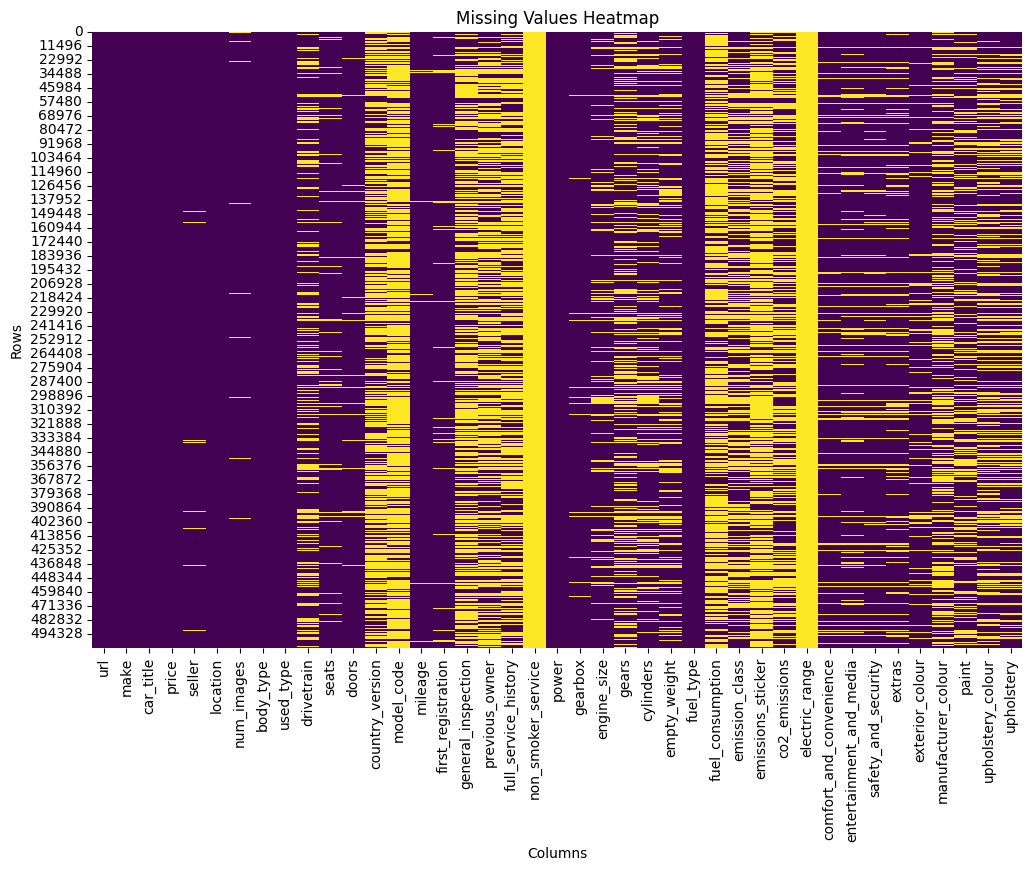

In [4]:
# Create a heatmap of missing values on the dataset
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

Clearly, there are many useless featues in our dataset, with either very large missing parts or fully empty ones, in the next step I will get rid of some, that we will not be using further for any analysis.

Note: We keep the url, as it is useful for validating data in case of e.g. outliers.

In [5]:
# Copy df and get shape before dropping duplicates
df_cleaned = df.copy()
print("Initial shape of the DataFrame:", df_cleaned.shape)
row_count_before = df_cleaned.shape[0]

# Drop useless columns
df_cleaned.drop(columns=["manufacturer_colour", "electric_range",
                "emissions_sticker", "non_smoker_service", "model_code", "country_version"], inplace=True)

Initial shape of the DataFrame: (505804, 41)


### Remove Missing Values

Then let's clean the missing values from our most important features.

- price
- mileage
- power


In [6]:
df_cleaned = df_cleaned[df_cleaned['price'].notnull()]
df_cleaned = df_cleaned[df_cleaned['mileage'].notnull()]
df_cleaned = df_cleaned[df_cleaned['power'].notnull()]

print("Shape of the DataFrame after removing rows with missing crucial information:", df_cleaned.shape)
row_count_after_na = df_cleaned.shape[0]
print("Removed: ", row_count_before - row_count_after_na)

Shape of the DataFrame after removing rows with missing crucial information: (495925, 35)
Removed:  9879


As we can see this has removed `9879` records, which is not an insignificant amount, but still not much compared to our dataset's size.

### Transform Columns into Usable Data

Let's transform our `first_registration` column into `age_months` so that we can make calculations with it.


In [7]:
# Turn the 'first_registration' column into a datetime object
df_cleaned['first_registration'] = pd.to_datetime(
    df_cleaned['first_registration'],
    format='%Y-%m', errors='coerce'
)

# Create age (years) and age_months (months) columns
# current_year = pd.Timestamp.now().year
# df_cleaned['age'] = current_year - df_cleaned['first_registration'].dt.year
current_date = pd.to_datetime('now')
df_cleaned['age_months'] = (current_date.year - df_cleaned['first_registration'].dt.year) * \
    12 + (current_date.month - df_cleaned['first_registration'].dt.month)

# Drop the 'first_registration' column
df_cleaned.drop(columns=['first_registration'], inplace=True, axis=1)

# Get the number of na values for `age_months`
print(df_cleaned['age_months'].isna().sum())

21454


We can see that there are `21454` missing values. This is a rather large portion of our dataset, let's try and see why this could be.

My initial thought is that maybe when a car is new, the first registration is not stated.


In [8]:
# Check how many rows are there where `used_type` is `new` or `demonstration` and `first_registration` is null
print(df_cleaned[(df_cleaned['used_type'].isin(['New', 'Demonstration'])) & (
    df_cleaned['age_months'].isna())].shape[0])

21454


As expected, the number of cars tagged as `New` or `Deomnstration` perfectly matches that of the missing `first_registration` values. To solve this issue, we may reasonably impute these missing values with `0` months as their age.


In [9]:
# Impute `age_months` missing values with 0
df_cleaned['age_months'].fillna(0, inplace=True)

/tmp/ipykernel_293998/4258893584.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['age_months'].fillna(0, inplace=True)


Now we should also transform the data that is most important regarding our country expolration, transfroming city level location data into just country codes.


In [10]:
# Split the 'location' string by comma, take the last part, and remove any whitespace.
df_cleaned["location"] = df_cleaned["location"].str.split(
    ',').str[-1].str.strip()

# Check the distribution of the 'location' column
print(df_cleaned['location'].value_counts())

location
DE    186874
IT    101153
NL     73441
ES     47848
BE     32200
FR     26897
AT     25582
LU      1905
          25
Name: count, dtype: int64


We should also transform `fuel_consumption` into a numeric format as it is now given in the format: `5.7 l/100 km (comb.)`


In [11]:
# Extract the first numeric value from the 'fuel_consumption' string and convert to float:
df_cleaned['fuel_consumption'] = df_cleaned['fuel_consumption'].str.extract(
    r'([\d\.]+)')[0]
df_cleaned['fuel_consumption'] = pd.to_numeric(
    df_cleaned['fuel_consumption'], errors='coerce')

# Check the result:
print(df_cleaned.loc[df_cleaned["fuel_consumption"].notnull(),
      "fuel_consumption"].head())

47   5.70
48   5.60
51   4.80
52   5.10
55   6.20
Name: fuel_consumption, dtype: float64


### Impute Data with Inferable Values

With domain knowledge of cars there are some missing data we could fill with 100% certainity:

- `fuel_type` = electric -> `co2_emissions` = 0
- `fuel_type` = electric -> `gearbox` = Automatic


In [12]:
# Check missing values before imputation:
print("Before imputation:")
print("Missing co2_emissions:", df_cleaned["co2_emissions"].isna().sum())
print("Missing gearbox:", df_cleaned["gearbox"].isna().sum())

# Create a mask where fuel_type is 'electric' (case-insensitive)
electric_mask = df_cleaned['fuel_type'].str.lower() == 'electric'

# Impute inferable values:
df_cleaned.loc[electric_mask, 'co2_emissions'] = 0
df_cleaned.loc[electric_mask, 'gearbox'] = 'Automatic'

# Check missing values after imputation:
print("\nAfter imputation:")
print("Missing co2_emissions:", df_cleaned["co2_emissions"].isna().sum())
print("Missing gearbox:", df_cleaned["gearbox"].isna().sum())

Before imputation:
Missing co2_emissions: 203231
Missing gearbox: 10467

After imputation:
Missing co2_emissions: 202974
Missing gearbox: 9713


This led to a slight improvement, roughly 1500 more datapoints.


### Clean Outliers

We may now clean the outliers of our dataset, however it is important that we take care when doing it, since there are many instances for valid outliers compared to the usual cars, e.g. luxury cars for price, muscle cars for power.


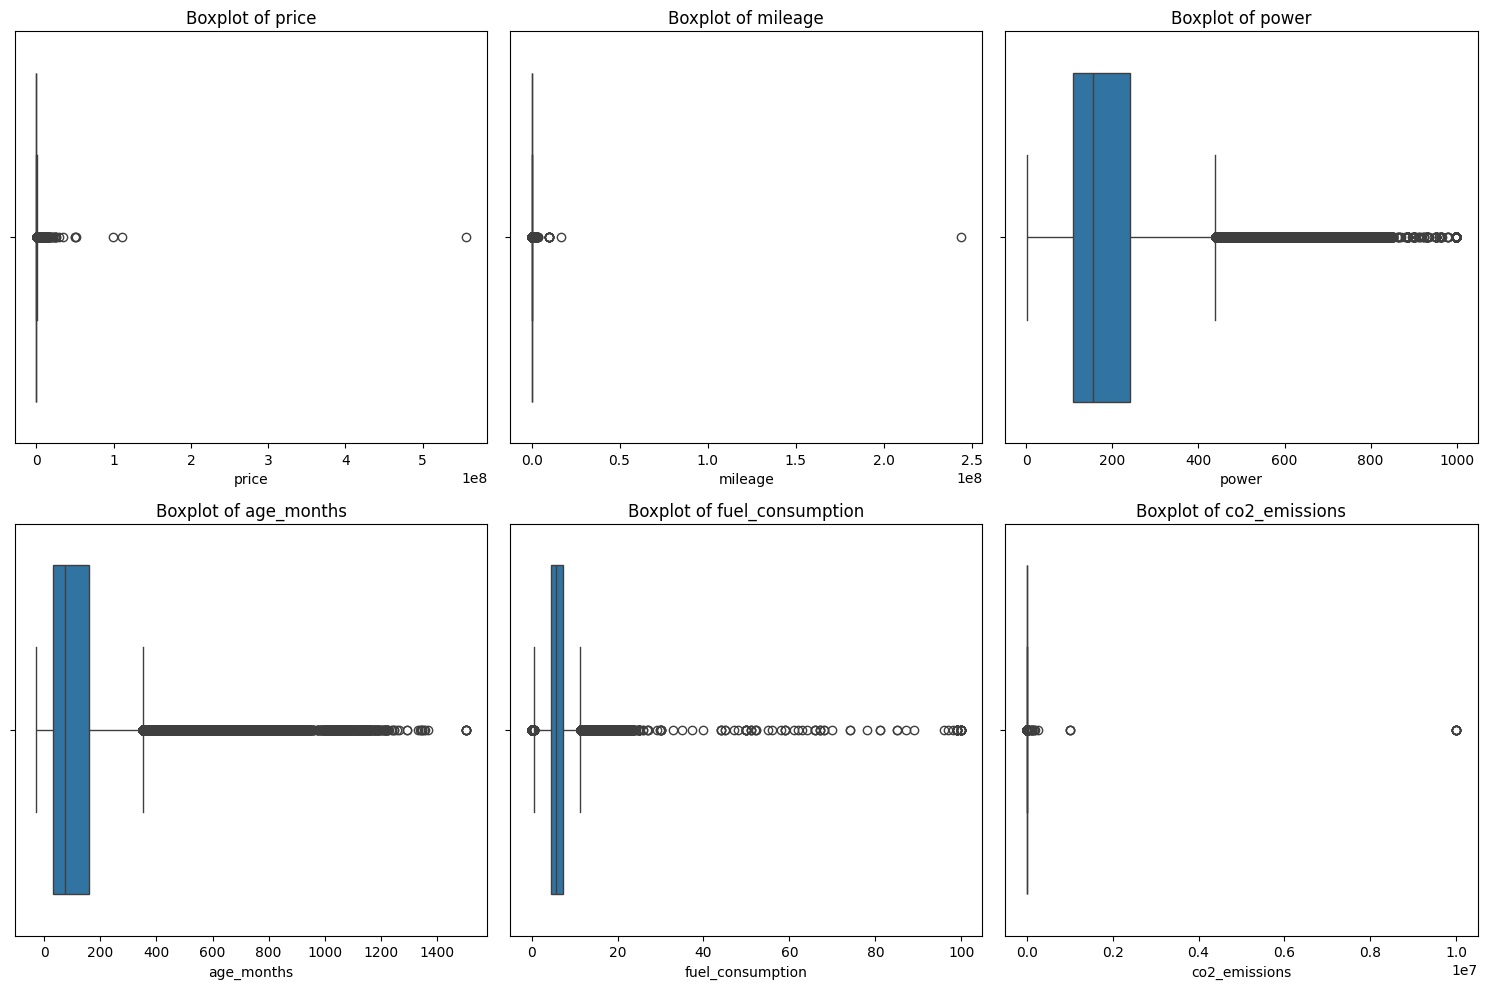

In [13]:
# Let's assume these are your numeric columns:
numeric_cols = ['price', 'mileage', 'power',
                'age_months', 'fuel_consumption', 'co2_emissions']

# Define the number of rows and columns for your subplot grid.
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to simplify iterating

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_cleaned[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see that in some cases we have very huge outliers we have to clean off, like `price`, `mileage`, `co2_emissions`. These needs to simply be cleaned.

In case of `power` I would say that knowing the context of how I collected the data by power ranges, it makes sense that there are outliers to the top of the range, but it is also feasible, so I will allow it.

The outliers of `fuel_consumption` seem to be a bit blotchy, and given the context it also does not make sense that a car may have a coumption of e.g. 100 liters / 100 kms. This needs to be cleaned.

For `age_months` we seem to have a lot of outliers the biggest outlier seemed to be about 1400 monts, which is roughly 116 years. This is not so realistic, unless it is an original Ford T-Model for example. We will have to inspect the instances in the tail to see if it makes sense to remove them.


#### Price Outliers

For price I feel like even a method like 1-99th percentile is too harsh, in case of our 500k large dataset it would mean getting rid of 5k of the most expensive cars, which may mean losing a great portion of the luxury car segment.

Here my solution is two-fold, I am planning on doing the following:

- Since car brand is a very good indicator of price (or at least it is for outlier luxury brands) I will do an IQR clean, but on a brand by brand basis.
- Then in the end cap both ends so that the values make sense for sure.


In [14]:
def filter_brand_iqr(df, group_col, target_col, k=2.0):
    def _clip(g):
        q1 = g[target_col].quantile(0.25)
        q3 = g[target_col].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - k*iqr, q3 + k*iqr
        return g[(g[target_col] >= lower) & (g[target_col] <= upper)]
    return df.groupby(group_col, group_keys=False).apply(_clip)


# apply per‐brand IQR filter with k=2.0
df_cleaned = filter_brand_iqr(df_cleaned, 'make', 'price', k=2.0)

/tmp/ipykernel_293998/362715879.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(_clip)


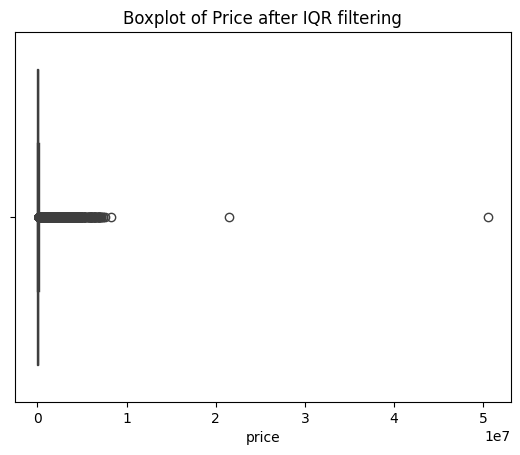

Shape of the DataFrame after filtering by IQR: (478028, 35)
Removed:  17897


In [15]:
# Show a boxplot of just the 'price' column
sns.boxplot(x=df_cleaned['price'])
plt.title('Boxplot of Price after IQR filtering')
plt.show()

# Check the shape of the DataFrame after filtering
row_count_after_iqr_price = df_cleaned.shape[0]
print("Shape of the DataFrame after filtering by IQR:", df_cleaned.shape)
print("Removed: ", row_count_after_na - row_count_after_iqr_price)

We can see that there are still some very big outliers, even this way that we got rid of big outliers compared to their own brand's IQR. Let's find a value for the minimum cap and also one for the maximum cap.


In [16]:
# Print counts of brands above X price
max_cap = 1000000
print(f"Brands with more than price: {max_cap}\n---")
above_cap = df_cleaned[df_cleaned['price'] > max_cap]['make'].value_counts()
for brand in above_cap.index:
    print(
        f"{brand}: {above_cap[brand]} - {round((above_cap[brand] / df_cleaned['make'].value_counts()[brand]) * 100, 2)}%")

# Overall removed rows
print("---\nOverall removed rows: ", above_cap.sum())

Brands with more than price: 1000000
---
porsche: 2837 - 14.66%
lamborghini: 489 - 38.44%
audi: 170 - 0.66%
mclaren: 156 - 44.83%
maserati: 142 - 4.47%
maybach: 44 - 53.66%
alpina: 42 - 13.12%
ineos: 15 - 9.8%
dallara: 5 - 38.46%
boldmen: 5 - 100.0%
pagani: 5 - 100.0%
lucid: 3 - 33.33%
techart: 3 - 33.33%
man: 3 - 0.34%
brute: 2 - 50.0%
acura: 1 - 33.33%
isuzu: 1 - 0.27%
koenigsegg: 1 - 100.0%
bugatti: 1 - 9.09%
rolls-royce: 1 - 0.15%
---
Overall removed rows:  3926


We can see that this cap of 1 million euros removes a few ultra premium brands completely, like `Bugatti` or `Pagani`, but given that there were so few of them this should not matter as much anyway.

What is more concerning is `Lamborghini` and `McLaren` losing about 40% of their records, `Porsche` losing almost 15%, but having experimented with different cutoff points, I think this still seems like a valid compromise, with the caveat that we will have to explore ultra-premium brands and cars separately if we want to.

Let's act similarly with the lower end.


In [17]:
# Define the minimum cap and get counts for rows with price below min_cap
min_cap = 500
below_counts = df_cleaned[df_cleaned['price'] < min_cap]['make'].value_counts()

# Get overall counts per brand
overall_counts = df_cleaned['make'].value_counts()

# Combine into a DataFrame and calculate the percentage removed per brand
df_removed = pd.DataFrame({
    'removed': below_counts,
    'total': overall_counts
}).fillna(0)
df_removed['pct_removed'] = (df_removed['removed'] / df_removed['total']) * 100

# Sort in descending order by percentage removed
df_removed = df_removed.sort_values(by='pct_removed', ascending=False)

print(df_removed)

                  removed  total  pct_removed
make                                         
trailer-anhänger     3.00     28        10.71
reliant              1.00     13         7.69
nsu                  2.00     36         5.56
daewoo               6.00    126         4.76
buick                2.00    110         1.82
...                   ...    ...          ...
xpeng                0.00    129         0.00
zastava              0.00     13         0.00
zaz                  0.00      2         0.00
zeekr                0.00     14         0.00
zhidou               0.00     22         0.00

[227 rows x 3 columns]


As we can see removing cars with prices lower than `500` euros, does not significantly remove any brand except for `trailer-anhänger` which turns out to be useless for us anyway, simply towable trailers. I will remove cars with this "make".


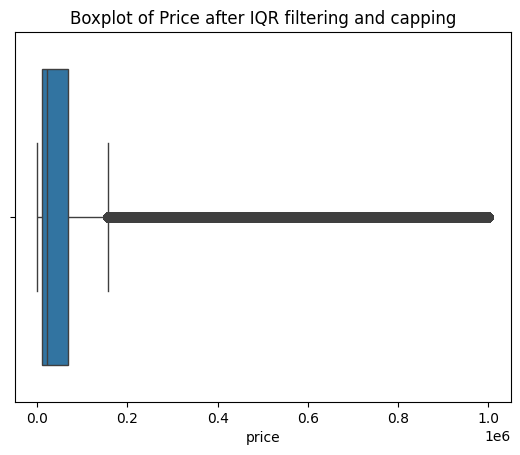

In [18]:
# Apply the caps
df_cleaned = df_cleaned[df_cleaned['price'] <= max_cap]
df_cleaned = df_cleaned[df_cleaned['price'] >= min_cap]

# Remove rows where make is "trailer-anhänger"
df_cleaned = df_cleaned[df_cleaned['make'] != "trailer-anhänger"]
num_rows_after_price_cap = df_cleaned.shape[0]

# Boxplot of price after filtering
sns.boxplot(x=df_cleaned['price'])
plt.title('Boxplot of Price after IQR filtering and capping')
plt.show()

### Mileage Outliers

The distribution of `mileage` is quite similar to that of price, with most of our records being lightly used or even brand new. This time however, we only have to create a upper cap as new cars with 0 kilometre are valid too.

Let's try a 0.5% cap from the top and see how it looks.


In [19]:
# Take off the highest 0.5% of mileage
mileage_cap = df_cleaned['mileage'].quantile(0.995)

num_rows_above_cap = df_cleaned[df_cleaned['mileage'] > mileage_cap].shape[0]
print(f"Number of rows above mileage cap: {num_rows_above_cap}")

df_cleaned = df_cleaned[(df_cleaned['mileage'].isna())
                        | (df_cleaned['mileage'] <= mileage_cap)]
num_rows_after_mileage_cap = df_cleaned.shape[0]

Number of rows above mileage cap: 2362


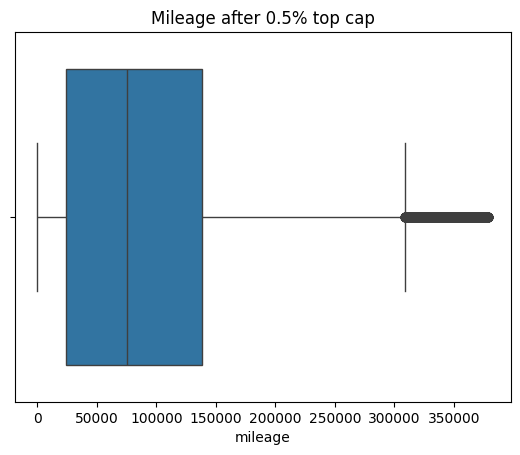

In [20]:
# Boxplot of mileage after filtering
sns.boxplot(x=df_cleaned['mileage'])
plt.title('Mileage after 0.5% top cap')
plt.show()

This looks good already, let's not remove more than necessary as we will keep on removing outliers for other features as well.

### CO2-Emissions Outliers

Similar situation to the ones before, 0 emissions is a valid option for many cars since techincally electric cars have none, we just have to find the top cap.

Let's try 0.5% once again.


In [21]:
# Take off the highest 0.5% of co2 emissions
co2_cap = df_cleaned['co2_emissions'].quantile(0.995)
print(f"CO2 cap: {co2_cap}")

num_rows_above_cap = df_cleaned[df_cleaned['co2_emissions'] > co2_cap].shape[0]
print(f"Number of rows above co2 cap: {num_rows_above_cap}")
print(f"Num rows before co2 cap: {df_cleaned.shape[0]}")

df_cleaned = df_cleaned[(df_cleaned['co2_emissions'].isna()) | (
    df_cleaned['co2_emissions'] <= co2_cap)]
num_rows_after_co2_cap = df_cleaned.shape[0]

CO2 cap: 397.0
Number of rows above co2 cap: 1377
Num rows before co2 cap: 470985


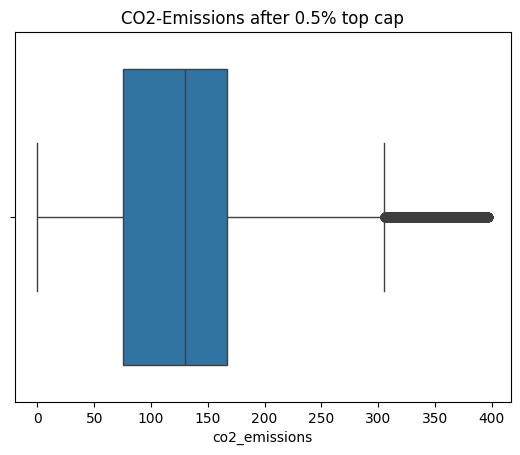

In [22]:
# Boxplot of co2 emissions after filtering
sns.boxplot(x=df_cleaned['co2_emissions'])
plt.title('CO2-Emissions after 0.5% top cap')
plt.show()

Looks good, actually better than expected.

### Fuel Consumption Outliers

In this case we will first have to check whether these high values may be justified somehow, before just removing them with an 0.5% cap like before. Based on the plot we can see that the consumptions above 25 are sparsely populated and this may serve as a great cutoff point.


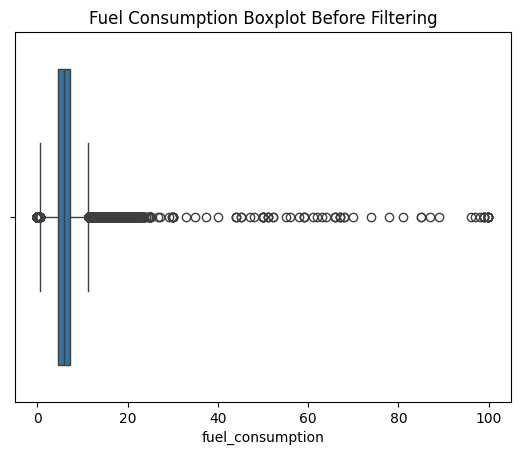

In [23]:
# Boxplot of Fuel Consumption before filtering
sns.boxplot(x=df_cleaned['fuel_consumption'])
plt.title('Fuel Consumption Boxplot Before Filtering')
plt.show()

In [24]:
# Inspect rows above fuel consumption of 20
fuel_top_cap = 20
print(
    f'Cutting off at {fuel_top_cap} liters/100km removes: {df_cleaned[df_cleaned["fuel_consumption"] > fuel_top_cap].shape[0]}')
df_cleaned = df_cleaned[(df_cleaned["fuel_consumption"].isna(
)) | (df_cleaned["fuel_consumption"] <= 20)]
num_rows_after_fuel_cap = df_cleaned.shape[0]

Cutting off at 20 liters/100km removes: 234


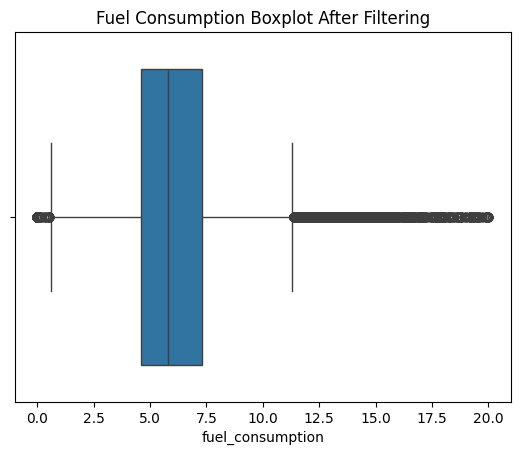

In [25]:
# Boxplot of Fuel Consumption after filtering
sns.boxplot(x=df_cleaned['fuel_consumption'])
plt.title('Fuel Consumption Boxplot After Filtering')
plt.show()

Inspecting the `fuel_consumption` once more we can now clearly see the distribution, there aren't too many large outliers.

### Age Outliers

Last up is `age_months`, lets see if the outliers seem to make sense, unfortunately the outliers don't seem to be as sparse here as it is in the case of fuel consumption.


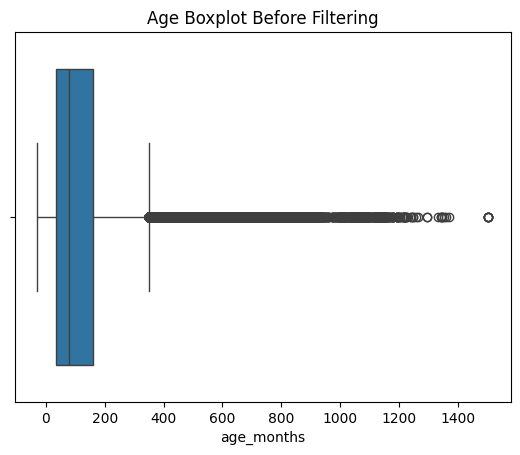

In [26]:
# Boxplot of age in months before filtering
sns.boxplot(x=df_cleaned['age_months'])
plt.title('Age Boxplot Before Filtering')
plt.show()

In [27]:
# Print the head of df_cleaned sorted in descending order by `age_months`
df_cleaned.sort_values(by='age_months', ascending=False).head(25)

,url,make,car_title,price,seller,location,num_images,body_type,used_type,drivetrain,...,co2_emissions,comfort_and_convenience,entertainment_and_media,safety_and_security,extras,exterior_colour,paint,upholstery_colour,upholstery,age_months
31961,https://www.autoscout24.com/offers/dfsk-fengon...,dfsk,DFSK Fengon,22450.00,Dealer,BE,7.00,Off-Road/Pick-up,New,None,...,NaN,Air conditioning;Cruise control;Electrical sid...,None,Central door lock;Power steering,None,Red,Others,Black,Cloth,1504.00
32290,https://www.autoscout24.com/offers/dfsk-fengon...,dfsk,DFSK Fengon,29990.00,Dealer,BE,11.00,Off-Road/Pick-up,New,None,...,NaN,Cruise control;Electrical side mirrors;Electri...,On-board computer,Central door lock;Power steering,Alloy wheels;Sport seats,White,Others,Black,Cloth,1504.00
31859,https://www.autoscout24.com/offers/dfsk-fengon...,dfsk,DFSK Fengon,22490.00,Dealer,BE,9.00,Off-Road/Pick-up,New,None,...,NaN,Air conditioning;Cruise control;Keyless centra...,On-board computer,Central door lock;Power steering,None,Grey,Others,Black,Cloth,1504.00
32360,https://www.autoscout24.com/offers/dfsk-fengon...,dfsk,DFSK Fengon,19990.00,Dealer,BE,8.00,Off-Road/Pick-up,New,None,...,NaN,Air conditioning;Navigation system;Park Distan...,None,Central door lock;Power steering,None,Black,Others,Black,Cloth,1504.00
181224,https://www.autoscout24.com/offers/baic-others...,baic,BAIC,357901.00,Dealer,BE,11.00,Off-Road/Pick-up,New,None,...,NaN,Cruise control;Electrical side mirrors;Electri...,On-board computer,ABS;Central door lock;Electronic stability con...,Alloy wheels,Silver,Metallic,Black,Cloth,1504.00
312653,https://www.autoscout24.com/offers/fiat-others...,fiat,Fiat,12500.00,Dealer,IT,11.00,Other,Used,None,...,NaN,None,None,None,None,Red,None,None,None,1504.00
330094,https://www.autoscout24.com/offers/oldtimer-ot...,oldtimer,Oldtimer,24999.00,Dealer,DE,17.00,Convertible,Antique / Classic,Rear,...,NaN,Leather seats,None,None,None,Yellow,None,Black,Full leather,1371.00
264680,https://www.autoscout24.com/offers/ford-others...,ford,Ford,22000.00,Private seller,NL,11.00,Convertible,Used,None,...,NaN,None,None,None,None,None,None,None,None,1360.00
271186,https://www.autoscout24.com/offers/ford-others...,ford,Ford,45900.00,Dealer,DE,17.00,Convertible,Used,None,...,NaN,None,None,None,None,Red,None,None,None,1355.00
274126,https://www.autoscout24.com/offers/ford-others...,ford,Ford,35000.00,Dealer,BE,17.00,Convertible,Used,None,...,NaN,Leather seats,None,None,None,Black,None,Black,Full leather,1348.00


Surprisingly, all of these 25 values at the end check out, they are valid cars from the 1960's, so in the end I have decided to not clean based on age. The boxplot did not seem too bad anyway.


### Outlier Cleaning - Conclusion

Now let's once again check out our combined subplot to visually inspect outliers and also numerically check how many rows have been removed.


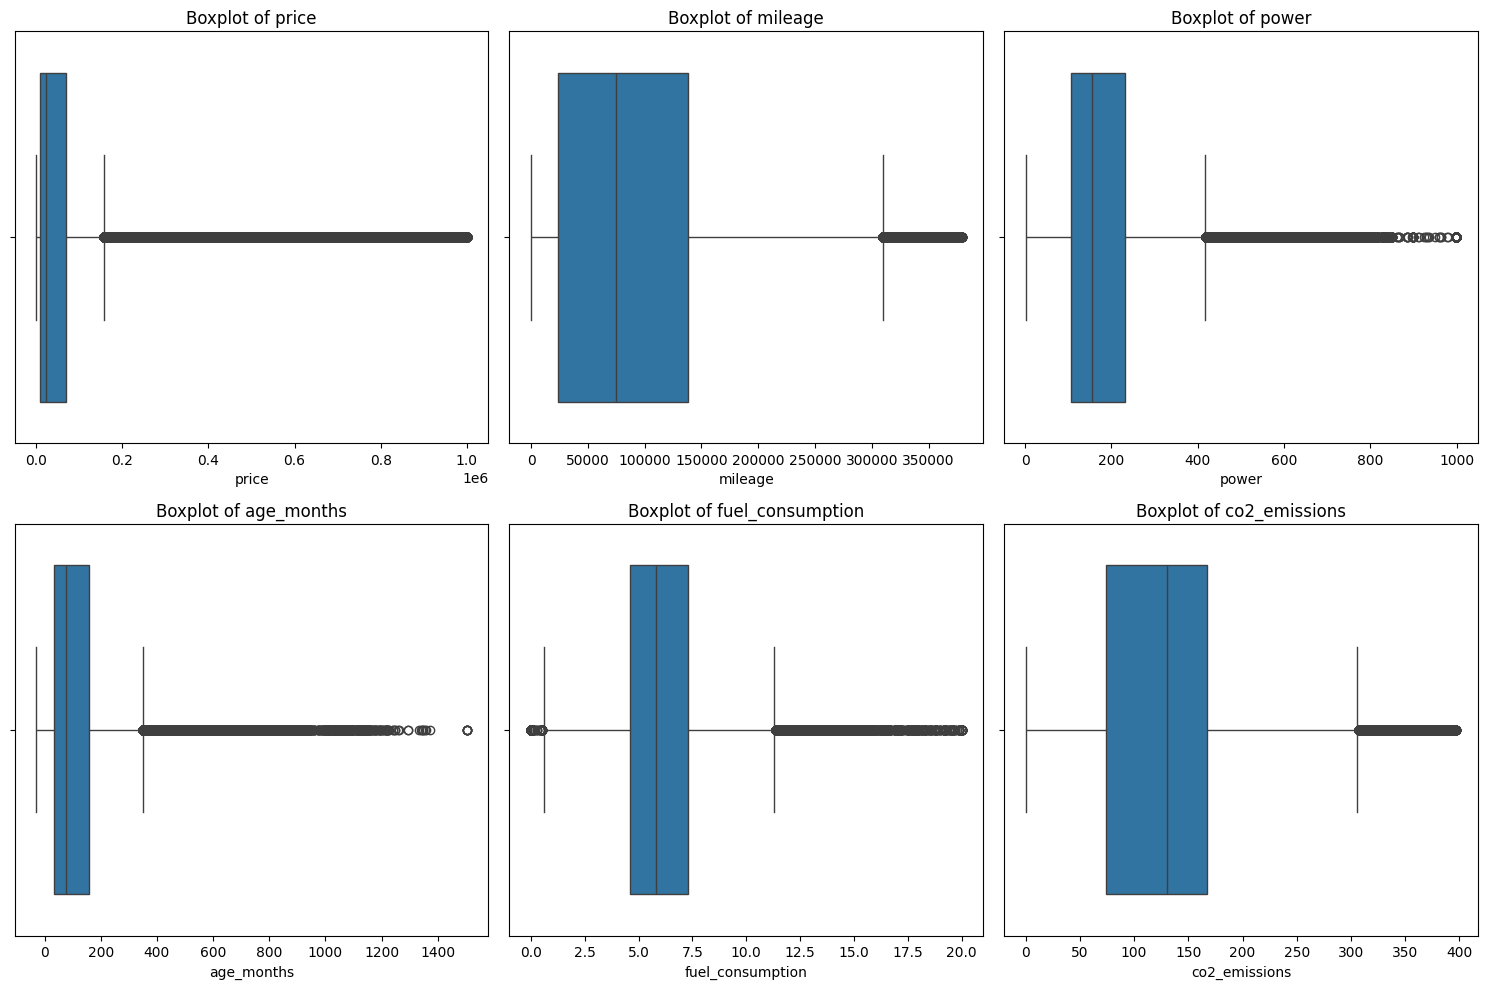

In [28]:
# Let's assume these are your numeric columns:
numeric_cols = ['price', 'mileage', 'power',
                'age_months', 'fuel_consumption', 'co2_emissions']

# Define the number of rows and columns for your subplot grid.
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to simplify iterating

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_cleaned[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove any unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The boxplots look a lot nicer than they did before, of course price has a lot of outliers, but that is as expected and we have tried addressing the most aggregous outliers by giving a hard upper and lower bound to the price + cleaning via IQR \* 2 based by car makes.


In [29]:
print("Outlier cleaning process:")
print("- After cleaning price:", num_rows_after_price_cap)
print("- After cleaning mileage:", num_rows_after_mileage_cap)
print("- After cleaning co2 emissions:", num_rows_after_co2_cap)
print("- After cleaning fuel consumption:", num_rows_after_fuel_cap)

print("\nNum rows before cleaning:", row_count_before)
print("- After cleaning NAs:", row_count_after_na)
print("- After IQR filtering:", df_cleaned.shape[0])
print("\nCleaning outliers removed additional rows: ",
      row_count_after_na - df_cleaned.shape[0])

Outlier cleaning process:
- After cleaning price: 473347
- After cleaning mileage: 470985
- After cleaning co2 emissions: 469608
- After cleaning fuel consumption: 469374

Num rows before cleaning: 505804
- After cleaning NAs: 495925
- After IQR filtering: 469374

Cleaning outliers removed additional rows:  26551


## Conclusion

This data cleaning was I would say successfull, we have removed some completely useless features, and drastically improved the distribution of our dataset by removing NAs, cleaning outliers. This all removed 7.2% of our records, which is not such a big deal, given our 504k strong starter dataset.

The two possible downsides of this cleaning are:

- Ultra premium car brands were lost in cases where the car costs more than 1 million euros, these brands and cars should be explored separately.
- In some cases we may have lost data for brands that have very big outliers compared to the average of their brand in price, given that these were out of 2 * IQR of the make. E.g. this could happen in cases where it is a regular everyday brand that happens to build some supercars too, like Nissan and their GTR line.


In [30]:
print("Shape before and after cleaning:")
print("- Before cleaning:", df.shape)
print("- After cleaning:", df_cleaned.shape)
print("- Overall removed rows: ", df.shape[0] - df_cleaned.shape[0])
print("- Overall removed rows in %: ", round(
    (df.shape[0] - df_cleaned.shape[0]) / df.shape[0] * 100, 2))

Shape before and after cleaning:
- Before cleaning: (505804, 41)
- After cleaning: (469374, 35)
- Overall removed rows:  36430
- Overall removed rows in %:  7.2


In [32]:
# Export the cleaned DataFrame to a new Parquet file
df_cleaned.to_parquet(
    "../all_car_details_cleaned.parquet", index=False, compression='gzip')